## 1. Import Module


In [ ]:
!pip install shap
!pip install xgboost

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

# 2. Data Preprocessing

In [ ]:
data = pd.read_csv('/content/cleaned_data.csv')
data

,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0,1,...,0.574400,1,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,2,9.110682
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,1,0,...,-9.753493,0,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,0,8.175281
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,1,0,...,-6.491034,0,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,0,1.283594
3,2021-01-01 03:00:00,36.649223,-70.190529,8.219558,3.095064,0.045257,0.573283,0.530186,0,1,...,-0.151276,1,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,0,9.304897
4,2021-01-01 04:00:00,30.001279,-70.012195,5.000075,3.216077,8.004851,914.925067,3.620890,0,0,...,2.429448,0,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,0,7.752484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32060,2024-08-28 20:00:00,48.496665,-104.031158,5.421806,4.394370,0.192421,127.684977,3.607803,0,1,...,-8.835069,0,9.893402,0.966050,0.109571,0.511074,0.953467,0.916745,0,5.506049
32061,2024-08-28 21:00:00,34.670137,-89.893091,10.624778,2.700635,8.736143,84.638889,1.218165,0,1,...,-2.517654,1,0.854378,1.665889,0.530289,0.868418,0.995329,0.808963,0,-1.876938
32062,2024-08-28 22:00:00,42.963338,-82.149873,5.071596,0.485288,7.420200,48.500920,4.999149,0,0,...,29.410878,1,4.480552,0.690990,0.537100,0.896798,0.442299,0.959197,2,9.790219
32063,2024-08-28 23:00:00,32.082410,-70.070154,5.000000,4.759411,0.932050,972.437425,0.505242,0,1,...,-6.951137,0,9.185549,4.462204,0.012896,0.463018,0.999999,0.557340,0,9.956879


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32065 entries, 0 to 32064
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   timestamp                        32065 non-null  object 
 1   vehicle_gps_latitude             32065 non-null  float64
 2   vehicle_gps_longitude            32065 non-null  float64
 3   fuel_consumption_rate            32065 non-null  float64
 4   eta_variation_hours              32065 non-null  float64
 5   traffic_congestion_level         32065 non-null  float64
 6   warehouse_inventory_level        32065 non-null  float64
 7   loading_unloading_time           32065 non-null  float64
 8   handling_equipment_availability  32065 non-null  int64  
 9   order_fulfillment_status         32065 non-null  int64  
 10  weather_condition_severity       32065 non-null  float64
 11  port_congestion_level            32065 non-null  float64
 12  shipping_costs    

In [ ]:
selected_columns = [
    "traffic_congestion_level",
    "warehouse_inventory_level",
    "loading_unloading_time",
    "historical_demand",
    "handling_equipment_availability",
    "weather_condition_severity",
    "port_congestion_level",
    "customs_clearance_time",
    "route_risk_level",
    "delay_probability"
]

data_selected = data[selected_columns]

## Data Scaling and Distributing



In [ ]:
x_data, y_data = data_selected.drop("delay_probability", axis=1), data_selected["delay_probability"]

In [ ]:
x_data

,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,historical_demand,handling_equipment_availability,weather_condition_severity,port_congestion_level,customs_clearance_time,route_risk_level
0,5.927586,985.716862,4.951392,100.772854,0,0.359066,4.289160,0.502006,1.182116
1,1.591992,396.700206,1.030379,5313.738114,1,0.230660,7.018373,0.966774,9.611988
2,8.787765,832.408935,4.220229,1595.049146,1,0.027210,9.605064,0.945627,6.570431
3,0.045257,0.573283,0.530186,2530.431941,0,0.616619,8.899616,4.674035,0.548952
4,8.004851,914.925067,3.620890,2146.190197,0,0.952385,0.061760,3.445429,8.861443
...,...,...,...,...,...,...,...,...,...
32060,0.192421,127.684977,3.607803,205.682808,0,0.792648,9.700832,0.966050,9.893402
32061,8.736143,84.638889,1.218165,1111.961023,0,0.034156,2.752909,1.665889,0.854378
32062,7.420200,48.500920,4.999149,600.132813,0,0.022338,0.498235,0.690990,4.480552
32063,0.932050,972.437425,0.505242,1354.437588,0,0.782338,9.697467,4.462204,9.185549


In [ ]:
preprocessor = Pipeline([
    ('normalizing', MinMaxScaler()),  # Normalizing numerical features
    ('standardizing', StandardScaler())  # Standardizing numerical features
])

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [ ]:
x_train = pd.DataFrame(preprocessor.fit_transform(x_train),
                       columns=x_data.columns,  # keep original names
                       index=x_train.index)

x_val = pd.DataFrame(preprocessor.transform(x_val),
                     columns=x_data.columns,
                     index=x_val.index)

# 3. Training a Model

In [ ]:
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",  # regression loss
    eval_metric="rmse",            # metric suited for regression
    random_state=42
)

param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 7, 15],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0]
}

In [ ]:
grid = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

grid.fit(x_train, y_train)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    feature_weights=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=No...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.05, 0.1],
                         'max_depth': [3, 5, 7, 15], 'n_estimators': [100, 200],
                         'subsample': [0.7, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:
best_model = grid.best_estimator_
y_pred = best_model.predict(x_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("Best Params:", grid.best_params_)
print("RMSE:", rmse)

Best Params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
RMSE: 0.3217771160698554


# 4. SHAP Plot

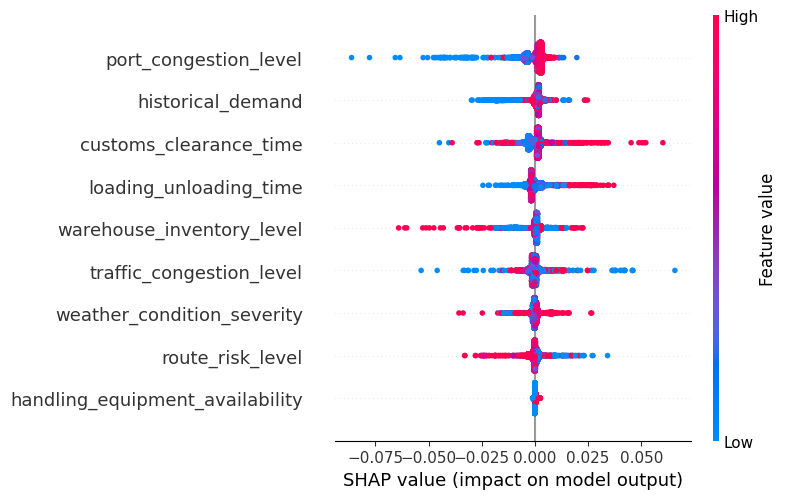

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(x_val)

shap.summary_plot(shap_values, x_val)  # Feature importance (global)